<a href="https://colab.research.google.com/github/hannaa-n/CS-491/blob/main/nguyennt2507_tf_idf_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. TF-IDF Vectorization

In [1]:
!pip install datasets transformers scikit-learn wordcloud matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset("sentence-transformers/wikihow")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/128543 [00:00<?, ? examples/s]

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.85,
    min_df=3,
    max_features=1000
)

tfidf_matrix = vectorizer.fit_transform(dataset['train']['text'])

## 2. Latent Sematic Analysis (LSA)

In [4]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=42)
lsa_matrix = svd.fit_transform(tfidf_matrix)

## 3. Evaluate Explained Variance

In [5]:
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.sum()

print(f"Cumulative Explained Variance: {cumulative_variance}")

Cumulative Explained Variance: 0.40944078620957686


## 4. Analyze Topics

In [6]:
import numpy as np

def get_top_documents_and_words(lsa_matrix, dataset, vectorizer, num_docs=5, num_words=10):
    topic_data = []
    for topic_idx in range(lsa_matrix.shape[1]):
        # Top documents
        doc_scores = lsa_matrix[:, topic_idx]
        top_doc_indices = np.argsort(doc_scores)[::-1][:num_docs]
        top_doc_titles = [dataset['train']['summary'][i] for i in top_doc_indices]

        # Top words
        feature_names = vectorizer.get_feature_names_out()
        top_word_indices = np.argsort(svd.components_[topic_idx])[::-1][:num_words]
        top_words = [feature_names[i] for i in top_word_indices]

        topic_data.append({
            'top_documents': top_doc_titles,
            'top_words': top_words
        })

    return topic_data

In [7]:
topic_data = get_top_documents_and_words(lsa_matrix, dataset, vectorizer)

# Print the data for the first topic as an example
print(topic_data[0])

{'top_documents': ['Make People Leave You Alone', 'Make a Beaded Bracelet', 'Do Subtle Yet Dramatic Makeup', 'Make a Good Montage in Halo ', 'Impress People'], 'top_words': ['make', 'want', 'like', 'people', 'time', 'just', 'way', 'need', 'easy', 'article']}


## 5. Visualize with Word Clouds



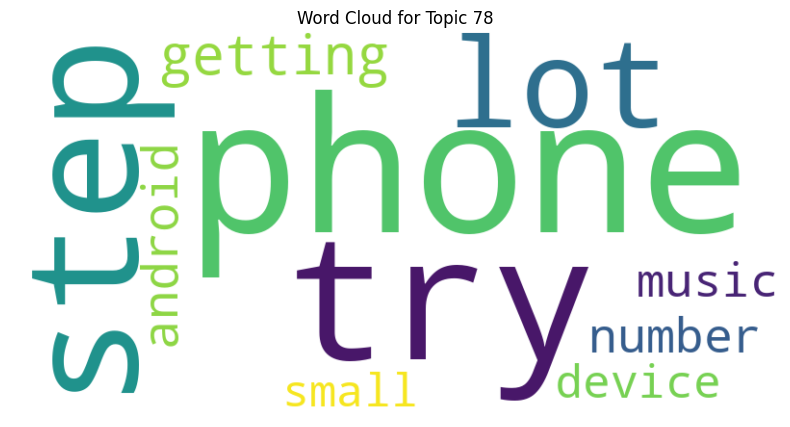

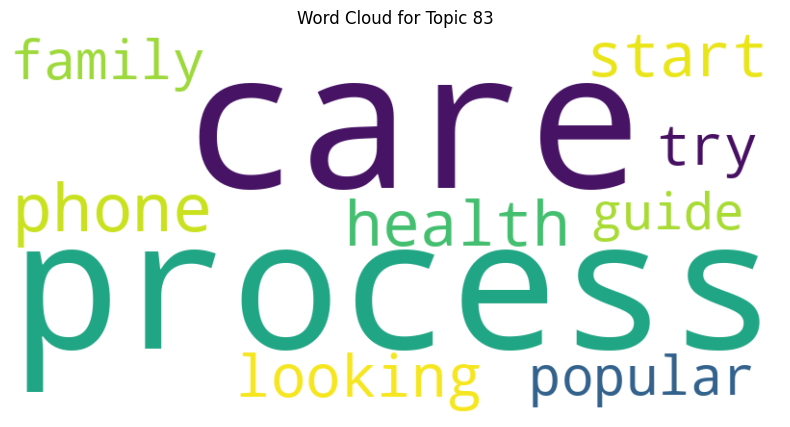

In [8]:
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Select two random topics (excluding the first topic)
random_topics = random.sample(range(1, lsa_matrix.shape[1]), 2)

for topic_idx in random_topics:
    # Get the top words for the topic
    top_words = topic_data[topic_idx]['top_words']

    # Create a dictionary of word frequencies
    frequencies = {word: svd.components_[topic_idx][vectorizer.vocabulary_[word]] for word in top_words if word in vectorizer.vocabulary_}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()